# Ensemble Climate Model EVA


This is a script to perform statistical climate change analysis on a single-model multi-member ensemble,
focussed on extreme events at a particular location.

Since the climate is not stationary, a climate model large ensemble is used to pull enough years from
a short date range. 

The code calculates and plots the following three items:

1. Map showing change in variable mean and where the changes are significant
2. Changes in extreme events at a given return period, with estimated uncertainty
3. Changes in monthly mean distributions

The script uses xarray and CMIP6 data stored in the google cloud, so no need to have data pre-downloaded. 
Only the data needed is loaded, which avoids having to download *full* GCM ensemble dataset. H

Total runtime is dependent on number of ensemble members available/specified



In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import gcsfs
import cartopy.crs as ccrs
from scipy.signal import find_peaks
import scipy.stats as stats
import warnings

### Define parameters

In [2]:

# set parameters for the analysis
n_ens_members=10         # number of ensemble members 
sig_level=1.0           # significant level for statistical analysis, this number is multiplied with the standard deviation

# load CMIP5 databases for google cloud
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')


# set model queries
# guide for names here: https://docs.google.com/document/d/1yUx6jr9EdedCOLd--CPdTfGDwEwzPpCF6p1jRmqx-0Q 
# firstly set queries for both ensemble
# the format of single and double quotation marks is important, so make sure these are kept 
variable = "'tasmax'"  
resolution = "'day'"
model=  "'CanESM5'"

# then, set the historical ensemble details
activity_1="'CMIP'"
scenario_1 = "'historical'"
date_1_start ="2005-01-01"
date_1_end = "2010-12-31"

# lastly, set the future ensemble details
activity_2="'ScenarioMIP'"
scenario_2 = "'ssp245'"
date_2_start ="2035-01-01"
date_2_end = "2040-12-31"

# time resolution of requested data, in days
ts_res_days=1 

# set coordinates for location to be analyzed
# use Brussels as example
xc=4.35
yc=50.85

# set return period to be tested
RP=100

# EVA factor: helper factor for GDP fit for extreme event analysis
# - if the variable values are very small (for example: precipitation 'pr'), the GDP fit is not accurate,
#   so it helps to adjust values to a more usable range. For precipiation 'pr', eva_func=10**5 works well
# - not needed for tasmax
eva_fac=1


### End define parameters

The next block builds the query. This is where the actual dataset is prescribed, since the rest of the code will loop through the dataframes df_hist and df_fut.

In [3]:
# data base queries
# historical ensemble query
df_hist = df.query("activity_id== " + activity_1 + " & source_id == "+model+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_1)

# future ensemble query
df_ssp = df.query("activity_id== " + activity_2 + " & source_id == "+model+" & table_id == "+resolution+" & variable_id == "+variable+" & experiment_id == "+scenario_2)
df_ssp


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
235244,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190306
235368,ScenarioMIP,CCCma,CanESM5,ssp245,r10i1p2f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190429
236745,ScenarioMIP,CCCma,CanESM5,ssp245,r1i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190429
236897,ScenarioMIP,CCCma,CanESM5,ssp245,r1i1p2f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r1...,NaN,20190429
237848,ScenarioMIP,CCCma,CanESM5,ssp245,r2i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r2...,NaN,20190306
237979,ScenarioMIP,CCCma,CanESM5,ssp245,r2i1p2f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r2...,NaN,20190429
238102,ScenarioMIP,CCCma,CanESM5,ssp245,r3i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r3...,NaN,20190306
238231,ScenarioMIP,CCCma,CanESM5,ssp245,r3i1p2f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r3...,NaN,20190429
238356,ScenarioMIP,CCCma,CanESM5,ssp245,r4i1p1f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r4...,NaN,20190306
238486,ScenarioMIP,CCCma,CanESM5,ssp245,r4i1p2f1,day,tasmax,gn,gs://cmip6/ScenarioMIP/CCCma/CanESM5/ssp245/r4...,NaN,20190429


Next, we define the functions that are used during the actual analysis section of the code later on.

In [4]:
## DEFINE FUNCTIONS FOR LATER USE


def standardize_dims(ds):
    # function to standardize dimension names in cmip models
    # dimension names get mapped to the keys in the rdic dictionary
    # ds = input array
    # code adapted from Julius Buseckes' CMIP6 pre-processing package
    rdic = {
        "lon": ["x", "i", "nlon", "lon", "longitude"],
        "lat": ["y", "j", "nlat", "lat", "latitude"],
        "lev": ["lev", "depth", "olevel", "zlev", "olev"],
        "time": ["time","t"],
        }
    for di in rdic.keys():
        if di not in ds.coords:
            for wrong in rdic[di]:
                if wrong in ds.coords:
                    ds=ds.rename({wrong: di})
    return ds


def prepare_timeseries(arr,xc,yc):
    # function to extract a single timeseries from an input ensemble at a given location, 
    # and returns it as a numpy array
    # arr = input array
    # xc = longitude coordinate
    # yc = latitude coordinate
    
    # select location
    ts_h=arr.sel(lon=xc,lat=yc, method="nearest")
    
    
    # since all the timeseries data is concatenated together, need to make note of the total number of years simulated
    n_yrs=(ts_h.time.dt.year.max()-ts_h.time.dt.year.min())*ts_h.count(dim='member')[0]  
    
    arr_np=xr.concat(ts_h,dim='time')
    return arr_np.values,n_yrs.values

def EVA(arr_np,n_yrs,RP,ts_res_days):
    xr.set_options(display_style='html')
    plt.rcParams['figure.figsize'] = 12, 6
    # function to calculate probability of extreme events using a generalized pareto distribution fit
    # we also calculate an uncertainty range using a bootstrapping method (this addressed sampling uncertainty)
    # returns distribtion of extreme event values at specified return period
    # arr_np  = input numpy array
    # n_yrs = number of years simulated
    # RP = return period to be tested
    
    # set variables
    
    n_events=100 # number of events to be extracted
    timegap_days=10 # minimum number of days between independant events
    threshold=np.percentile(arr_np,95); # set initial threshold for peak-over-threshold extreme events selection, using 99.9th percentile
    bootstrap_n=50 # number of bootstrap samples 
    
    # extract peaks
    peaks = extract_peaks(ts_res_days,arr_np,n_events,timegap_days,threshold)
    # update threshold so the lowest value in peaks is close to zero
    threshold = peaks[0]-(peaks[1]-peaks[0])/10
    peaks=peaks-threshold
    print('Threshold: '+str(threshold))
    # calculate empirical cumulative distribution function
    q_peaks,p_peaks=ecdf(peaks+threshold)
    xx = np.linspace(0,np.max(q_peaks-threshold)*3,100)
    #initialize arrays to hold bootstrapped GPD distributions (gp_fits) and returns values (rvs)
    gp_fits=np.zeros((bootstrap_n,len(xx)))
    rvs=np.zeros((bootstrap_n,1))
    # run bootstrapping fit
    for k in range(bootstrap_n):
        # select random sample, with replacement
        b_sample=np.random.choice(peaks,len(peaks),replace=True)
        # calculate CDF
        q_peaks,p_peaks=ecdf(b_sample+threshold)
        # temporarily disable specific warnings during fitting for ease of use
        # note : other extreme value functions are simpler/cleaner to fit but are not a general as the GPD
        with np.errstate(divide='ignore', invalid='ignore'): 
            # fit GPD function
            shape, loc, scale = stats.genpareto.fit(b_sample)
        # produce continuous probability density function
        yy = stats.genpareto.pdf(xx, shape, loc, scale)
        # convert to cumumative probability from PDF
        p_gp=np.cumsum(yy)/np.sum(yy)
        # plot fits
        plt.plot(1-np.exp(-(len(peaks)/n_yrs)*(1-p_gp)),xx+threshold, 'k',alpha=0.1)
        gp_fits[k,:]=1-np.exp(-(len(peaks)/n_yrs)*(1-p_gp))
        # calculate return value at specified return period RP
        idx = (np.abs(1-np.exp(-(len(peaks)/n_yrs)*(1-p_gp)) - 1/RP)).argmin()
        rvs[k]=xx[idx]+threshold 
    # plot 50th, 10th and 90th percentiles of fits on top of individual fits
    q_peaks,p_peaks=ecdf(peaks+threshold)
    gp_p50=np.percentile(gp_fits,50,axis=0)
    plt.plot(gp_p50,xx+threshold, 'r',linewidth=2,label='50th percentile')
    gp_p10=np.percentile(gp_fits,10,axis=0)
    plt.plot(gp_p10,xx+threshold, 'r:')
    gp_p90=np.percentile(gp_fits,90,axis=0)
    plt.plot(gp_p90,xx+threshold, 'r:',label='10-90 percentile')    
    plt.plot(1-np.exp(-(len(peaks)/n_yrs)*(1-p_peaks)),q_peaks,'bo',label='Data')
    plt.xscale('log')
    plt.xlim((10**-3, 1))
    locs, labels = plt.xticks()
    plt.xticks([1/1000, 1/100 ,1/50 ,1/25, 1/10 ,1], [1000, 100,50 ,25, 10 ,1])
    plt.xlabel('Return period')
    plt.legend()
    return rvs
    
def ecdf(sample):
    # function to calculate empirical cumulative distribution function
    # make numpy array
    # this code is adapted from stackoverflow
    sample = np.atleast_1d(sample)

    # produce quantiles and probabilities
    quantiles, counts = np.unique(sample, return_counts=True)

    # sum togther for cumulative distribution function
    cumprob = np.cumsum(counts).astype(np.double) / sample.size

    return quantiles, cumprob        
        
    
def extract_peaks(ts_res_days,timeseries,n_events,timegap_days,threshold):
    # function extract the top n_events independent events from a timeseries
    # ts_res_days = time resolution of input data, in number of days
    # timeseries = input timeseries
    # n_events = number of events to extract
    # timegap_days = the minimum number of days between independent events, default used is 5 days
    peaks, _ = find_peaks(timeseries,distance=timegap_days/ts_res_days,height=threshold)
    arr_s=np.sort(timeseries[peaks])[-n_events:]
    return arr_s

def plot_significant_changes(arr_past,arr_future,sig_level, n_ens_members):
    xr.set_options(display_style='html')
    plt.rcParams['figure.figsize'] = 18, 9
    # function to take two ensembles, plot the mean difference and show where the means are statistically different
    # arr_past = past ensemble
    # arr_future = future ensemble
    # sig_level = significance level, to be multiplied by the sample standard deviation
    # n_ens_members = number of ensemble members in input
    ts1=arr_past.mean(dim="time") # take time mean of each ensemble member
    ts2=arr_future.mean(dim="time") # take time mean of each ensemble member
    ts=ts2-ts1
    ts_m=ts.mean(dim='member') # ensemble mean difference 
    ts_std=sig_level*ts.std(dim='member')/(n_ens_members**(1/2)) # standard deviation 
    sig_map= ts_m.where(abs(ts_m)<ts_std) # calculate map for significance test
    # set up map, centred around the location of interest
    ax = plt.axes(projection=ccrs.Orthographic(xc, yc))
    ax.coastlines() # add coastlines
    # plot data
    ts_m.plot(subplot_kws=dict(projection=ccrs.Orthographic(xc-90, xc+90)),transform=ccrs.PlateCarree())
    
    # an error is generated when the entire map is significant, which is caught here
    # hashing is shown where the difference in the means is not significant
    try:
        p = sig_map.plot.contourf(subplot_kws=dict(projection=ccrs.Orthographic(xc-90, xc+90)),transform=ccrs.PlateCarree(),hatches=['///'],alpha=0)
        p.colorbar.remove()
    except:
        print('Significant everywhere')
        
    # plot location
    ax.plot(xc,yc,'co')
    ax.set_global()
    fig = plt.gcf()
    plt.title("Change in mean " + arr_past.long_name )
    fig.savefig('anomaly_map.png', dpi=200)
    return ts_m, ts_std

    
def is_significant(test1,test2,sig_level):
    # function to test significance of two input arrays
    if abs(np.mean(test1)  - np.mean(test2)) > sig_level*(np.std(test1)**2 + np.std(test2)**2   )**(1/2):
        return True
    else: 
        return False
    
    
class ENS_month:
    # This is a helper class that makes it easier to perform several varieties of monthly ensemble calculations
    def __init__(self,ens_hist,ens_fut,n_ens_members,sig_level):
        self.historical=ens_hist
        self.future=ens_fut
        self.n_ens = n_ens_members
        self.sig_l = sig_level
        
    def plot_mean_change(self,xc,yc):
        # this method calculates and plots distributions of monthly means
        # calculate monthly means first
        mn_hist=self.historical.sel(lon=xc,lat=yc, method="nearest").groupby('time.month').mean()
        mn_fut=self.future.sel(lon=xc,lat=yc, method="nearest").groupby('time.month').mean()
        # plot histograms
        make_histograms(mn_hist,mn_fut,self.n_ens,self.sig_l,'mean')
   
        
    def plot_max_change(self,xc,yc):
        # this method calculates and plots distributions of monthly maxima
        # calculate monthly maxima first
        mn_hist=self.historical.sel(lon=xc,lat=yc, method="nearest").groupby('time.month').max()
        mn_fut=self.future.sel(lon=xc,lat=yc, method="nearest").groupby('time.month').max()
        # plots histograms
        make_histograms(mn_hist,mn_fut,self.n_ens,self.sig_l,'max') 

        
    def plot_min_change(self,xc,yc):
        # this method calculates and plots distributions of monthly minima
        # calculate monthly minima first
        mn_hist=self.historical.sel(lon=xc,lat=yc, method="nearest").groupby('time.month').min()
        mn_fut=self.future.sel(lon=xc,lat=yc, method="nearest").groupby('time.month').min()
        # plot histograms
        make_histograms(mn_hist,mn_fut,self.n_ens,self.sig_l,'min') 

    
        
def make_histograms(mn_hist,mn_fut,n_ens_members,sig_level,title_str):
    # function to plot histograms: one distribution per input ensemble, for every month of the year
    # set up figure properties
    xr.set_options(display_style='html')
    plt.rcParams['figure.figsize'] = 12, 6
    f, axs = plt.subplots(3,4, sharex=True, sharey=True)
    mn_list=['January','February','March','April','May','June','July',
             'August','September','October','November','December']
    axs = axs.ravel()
    # cycle through all months and plot distributions
    for m in range(12):
        mn_hist.sel(month=m+1).plot.hist(ax=axs[m],alpha=0.7,bins=int(n_ens_members/2))
        mn_fut.sel(month=m+1).plot.hist(ax=axs[m],alpha=0.7,bins=int(n_ens_members/2))
        plt.subplots_adjust(hspace = 0.5)
        # test if distributions are significantlt different and use result as title
        if is_significant(mn_hist.sel(month=m+1).values,mn_fut.sel(month=m+1).values,sig_level):
            axs[m].title.set_text('Significant')
        else:
            axs[m].title.set_text('Not Significant')
        axs[m].set_xlabel(mn_list[m])
    fig = plt.gcf()
    fig.savefig('monthly_'+title_str+'.png', dpi=200)
    
### END DEFINE FUNCTIONS

### Get data from the cloud

In [5]:
# initialize gcfs token
print('Setting up database queries')
gcs = gcsfs.GCSFileSystem(token='anon')

# check that there are enough ensemble members for the specified analysis, otherwise update the specified number
if df_ssp.shape[0] < n_ens_members:
    n_ens_members=df_ssp.shape[0]
    print('Ensemble members updated to '+str(n_ens_members))
    

# these two loops pull the past and future ensemble data from the cloud
for i in range(n_ens_members):
    zstore = df_hist.zstore.values[i]

    # create a mutable-mapping-style interface to the store 
    mapper = gcs.get_mapper(zstore)

    # open data and select time slice 
    ds = xr.open_zarr(mapper, consolidated=True)
    ens_m=ds[variable[1:-1]].sel(time=slice(date_1_start,date_1_end))
    if i == 0:
        ens_hist=ens_m
    else:
        ens_hist=xr.concat([ens_hist,ens_m], 'member')

        
for i in range(n_ens_members):
    zstore = df_ssp.zstore.values[i]

    # create a mutable-mapping-style interface to the store 
    mapper = gcs.get_mapper(zstore)

    # open data and select time slice 
    ds = xr.open_zarr(mapper, consolidated=True)
    ens_m=ds[variable[1:-1]].sel(time=slice(date_2_start,date_2_end))
    if i == 0:
        ens_fut=ens_m
    else:
        ens_fut=xr.concat([ens_fut,ens_m], 'member')

# rename dimensions to standard names
ens_hist=standardize_dims(ens_hist)
ens_fut=standardize_dims(ens_fut)

Setting up database queries


In [6]:
# load data now, so all analyses can be performed quickly
# this step takes time!

print('Loading data')
%time ens_hist.load()
%time ens_fut.load()

Loading data
CPU times: user 28.3 s, sys: 11.3 s, total: 39.6 s
Wall time: 4min 20s
CPU times: user 42.1 s, sys: 16.2 s, total: 58.2 s
Wall time: 6min 30s


<xarray.DataArray 'tasmax' (member: 10, time: 2190, lat: 64, lon: 128)>
array([[[[253.44237, 254.0305 , 253.11916, ..., 254.13193, 253.8277 ,
          254.6295 ],
         [253.19223, 252.70169, 252.30077, ..., 255.88419, 254.85475,
          253.77655],
         [255.68463, 255.33803, 254.56485, ..., 256.99963, 256.36044,
          256.09064],
         ...,
         [270.69653, 270.2646 , 269.8216 , ..., 270.1178 , 270.6859 ,
          270.83823],
         [264.80032, 264.40274, 263.84372, ..., 265.23685, 265.26257,
          265.124  ],
         [258.74542, 258.88605, 258.68967, ..., 259.61328, 259.31454,
          258.67862]],

        [[254.64366, 254.44478, 254.20169, ..., 255.34283, 255.34874,
          255.01111],
         [256.59198, 256.23398, 255.90717, ..., 257.98947, 257.55228,
          257.0142 ],
         [256.37064, 255.9263 , 255.44505, ..., 258.5546 , 258.27402,
          256.91995],
         ...,
         [269.7563 , 269.1617 , 268.4317 , ..., 270.04333, 270.06674,
          270.1635 ],
         [265.3171 , 264.93445, 264.15005, ..., 266.84598, 266.41074,
          265.83524],
         [262.32056, 262.00577, 261.70328, ..., 263.10785, 262.81964,
          262.4567 ]],

        [[255.85689, 255.89948, 255.78162, ..., 256.74902, 256.471  ,
          256.40036],
         [257.54263, 257.20093, 256.60736, ..., 258.75992, 258.54456,
          257.9645 ],
         [256.78433, 255.7699 , 254.82414, ..., 259.01895, 258.01065,
          257.03522],
         ...,
         [265.83835, 265.66864, 265.41962, ..., 267.37   , 266.7687 ,
          266.14105],
         [260.9104 , 260.3218 , 259.6485 , ..., 263.16037, 262.353  ,
          261.65573],
         [261.32605, 260.97595, 260.64697, ..., 261.9048 , 261.55966,
          261.18076]],

        ...,

        [[262.6253 , 262.28262, 262.0867 , ..., 262.74994, 262.6326 ,
          262.52084],
         [260.92755, 260.8375 , 260.64575, ..., 261.96768, 261.49704,
          261.17285],
         [261.12   , 261.21527, 261.37955, ..., 262.16626, 261.5992 ,
          261.30292],
         ...,
         [254.54205, 257.45856, 261.25848, ..., 250.0154 , 251.6738 ,
          253.52203],
         [246.79762, 248.05716, 249.31857, ..., 243.2275 , 244.26735,
          245.4747 ],
         [240.82239, 240.77127, 240.89978, ..., 240.97304, 240.93997,
          240.51147]],

        [[262.11768, 261.46417, 261.5831 , ..., 262.0267 , 261.32043,
          261.71588],
         [262.0908 , 261.33707, 260.73337, ..., 263.30832, 262.78635,
          262.24472],
         [260.88947, 260.91248, 261.0782 , ..., 261.88165, 261.46246,
          261.006  ],
         ...,
         [249.7894 , 254.41783, 259.8594 , ..., 240.83339, 244.10733,
          247.57681],
         [246.26122, 247.5046 , 248.70973, ..., 243.69363, 244.32185,
          245.41434],
         [241.67285, 241.51181, 241.39514, ..., 242.38324, 242.2172 ,
          241.82417]],

        [[260.20844, 259.91977, 260.02332, ..., 259.7953 , 259.99808,
          259.93854],
         [262.2989 , 262.06207, 262.18765, ..., 263.04138, 262.52487,
          262.08023],
         [261.76944, 261.56174, 261.56152, ..., 262.73798, 261.67307,
          261.93304],
         ...,
         [257.86325, 260.07465, 262.1243 , ..., 250.40875, 253.1252 ,
          255.47603],
         [247.90791, 248.92995, 250.0448 , ..., 244.50269, 245.6229 ,
          246.74979],
         [240.02443, 240.21338, 240.66682, ..., 240.34877, 240.18762,
          240.02231]]],


       [[[253.5822 , 253.01346, 252.79984, ..., 254.18178, 254.31915,
          253.64313],
         [254.33005, 253.5698 , 252.96574, ..., 256.01907, 255.52657,
          254.88501],
         [257.2929 , 256.53918, 256.04922, ..., 258.1246 , 258.12357,
          257.44366],
         ...,
         [273.55032, 273.7709 , 273.80807, ..., 270.77176, 272.1991 ,
          273.06836],
         [269.3993 , 269.9412 , 270.40656, ..., 267.10132, 267.7949 ,
          268.58868],
         [270.4115 , 270.49097

### Plot significant differences between the two ensembles

Plotting significant changes...
Units are in K
Location marked in centre
Hashed areas are not statisically significant


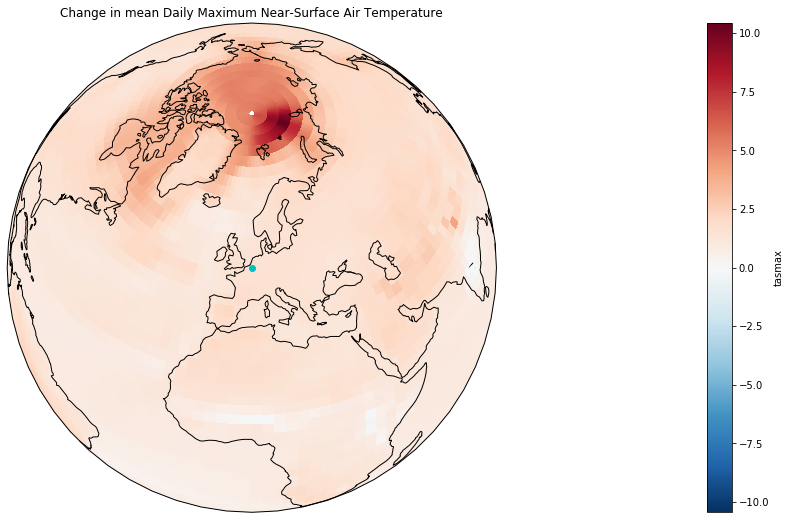

In [7]:
print('Plotting significant changes...')
a_m,a_std = plot_significant_changes(ens_hist,ens_fut,sig_level, n_ens_members)
print('Units are in '+ ens_hist.units)
print('Location marked in centre')
print('Hashed areas are not statisically significant')

### Calculate and plot estimated return values for extreme events

The sampling uncertainty is estimated using bootstrapping only, so far.

Evaluating extreme event changes
Threshold: 301.1611846923828
Return value of Daily Maximum Near-Surface Air Temperature at year 100 is: 305.79 +/- 0.24 K


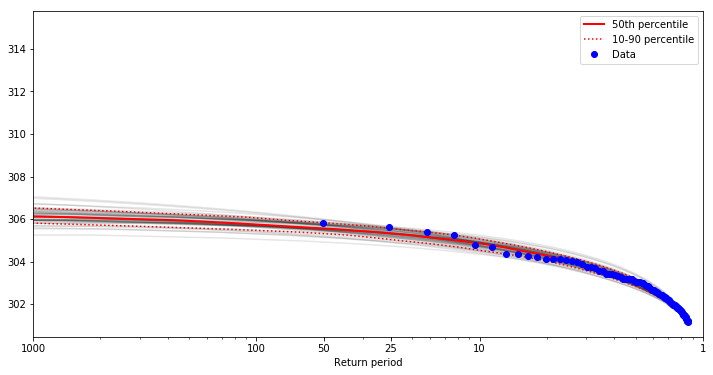

In [8]:
# evaluate return periods over the historical period 
print('Evaluating extreme event changes')
# prepare timeseries
arr_n,n_yrs = prepare_timeseries(ens_hist,xc,yc)
# run EVA analysis
rvs_hist=EVA(eva_fac*arr_n,n_yrs,RP,ts_res_days)
fig = plt.gcf()
fig.savefig('EVA_historical.png', dpi=200)
print("Return value of " + ens_hist.long_name+ " at year " + str(RP)+ " is: "+ str(round(np.mean(rvs_hist),2)/eva_fac)
      + " +/- " + str(round(sig_level*np.std(rvs_hist),2)/eva_fac) + " " + ens_hist.units)

In [9]:
plt.close('all')

Threshold: 302.9083679199219
Return value of Daily Maximum Near-Surface Air Temperature at year 100 is: 308.25 +/- 0.43 K


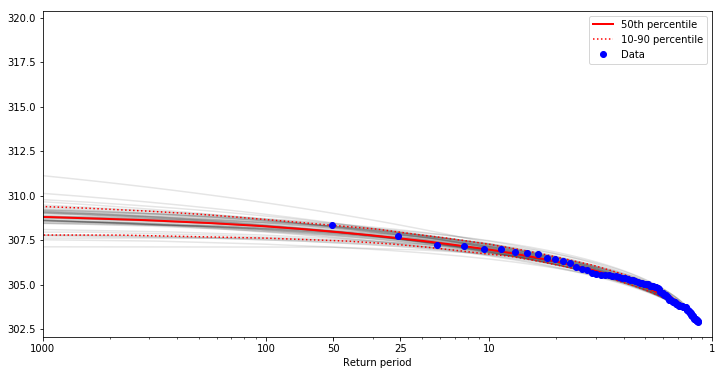

In [10]:
# repeat return periods calculate for the future period 
arr_n,n_yrs = prepare_timeseries(ens_fut,xc,yc)
rvs_fut=EVA(eva_fac*arr_n,n_yrs,RP,ts_res_days)
fig = plt.gcf()
fig.savefig('EVA_future.png', dpi=200)
print("Return value of " + ens_hist.long_name+ " at year " + str(RP)+ " is: "+ str(round(np.mean(rvs_fut),2)/eva_fac)
      + " +/- " + str(round(sig_level*np.std(rvs_fut),2)/eva_fac) + " " + ens_hist.units)

In [11]:
plt.close('all')

### Test for significance
This next cell calculates whether there is a significant change in the specified return period extreme event

In [12]:
# test significance

    
print('Significance test:')
if is_significant(rvs_fut,rvs_hist,sig_level):
    print("Likely significant change in " + ens_hist.long_name+ " at year " + str(RP) + " from " + str(round(np.mean(rvs_hist),2)/eva_fac) + 
    " to "+ str(round(np.mean(rvs_fut),2)/eva_fac)+ " " + ens_hist.units)
else: 
    print("Likely no change in " + ens_hist.long_name+ " at year " + str(RP) + " from " + str(round(np.mean(rvs_hist),2)/eva_fac)+ " "+ ens_hist.units)    
     

Significance test:
Likely significant change in Daily Maximum Near-Surface Air Temperature at year 100 from 305.79 to 308.25 K


### Monthly differences

Plot histograms of monthly means, maxima, and/or minima

Plotting monthly changes


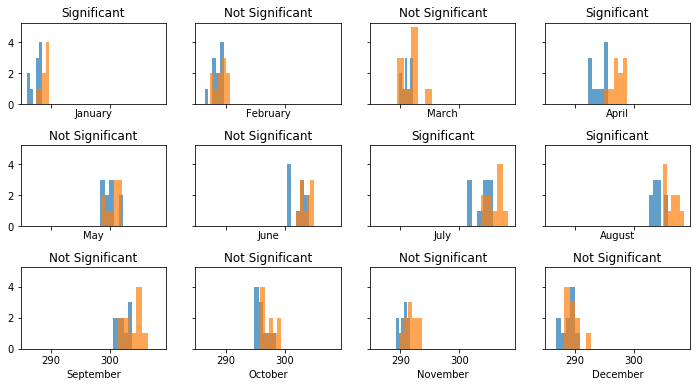

In [13]:
print('Plotting monthly changes')
ENS_month(ens_hist,ens_fut,n_ens_members,sig_level).plot_max_change(xc,yc)
